In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType ,IntegerType, FloatType ,DateType,TimestampType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly
plotly.offline.init_notebook_mode (connected = True)
import plotly.express as px
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA,PCA,TruncatedSVD
import calendar


spark  =  SparkSession \
    .builder \
    .appName("SalesData") \
    .getOrCreate()

__nvoiceNo__:
 - Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
 
__StockCode__:
 - Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
 
__Description__:
 - Product (item) name. Nominal.
 
__Quantity__:
- The quantities of each product (item) per transaction. Numeric.

__InvoiceDate__:
- Invice Date and time. Numeric, the day and time when each transaction was generated.

__UnitPrice__:
- Unit price. Numeric, Product price per unit in sterling.

__CustomerID__:
- Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

__Country__:
- Country name. Nominal, the name of the country where each customer resides

In [0]:
schema = StructType([
  StructField("nvoiceNo",IntegerType(),True),
  StructField("StockCode",IntegerType(),True),
  StructField("Description",StringType(),True),
  StructField("Quantity",IntegerType(),True),
  StructField("InvoiceDate",StringType(),True),
  StructField("UnitPrice",FloatType(),True),
  StructField("CustomerID",IntegerType(),True),
  StructField("Country",StringType(),True),
])

## load csv data

In [0]:
sales_data_path = "dbfs:/FileStore/shared_uploads/amitos684@gmail.com/Online_Retail_var2.csv"


sales_raw_df = (spark.read
                    .format("csv")
                    .option("header", "true") 
                    .schema(schema)
                    .load(sales_data_path) 
               )

In [0]:
sales_raw_df.show(10)


+--------+---------+--------------------+--------+----------------+---------+----------+--------------+
nvoiceNo|StockCode| Description|Quantity| InvoiceDate|UnitPrice|CustomerID| Country|
+--------+---------+--------------------+--------+----------------+---------+----------+--------------+
 536365| null|WHITE HANGING HEA...| 6|01/12/2010 08:26| 2.55| 17850|United Kingdom|
 536365| 71053| WHITE METAL LANTERN| 6|01/12/2010 08:26| 3.39| 17850|United Kingdom|
 536365| null|CREAM CUPID HEART...| 8|01/12/2010 08:26| 2.75| 17850|United Kingdom|
 536365| null|KNITTED UNION FLA...| 6|01/12/2010 08:26| 3.39| 17850|United Kingdom|
 536365| null|RED WOOLLY HOTTIE...| 6|01/12/2010 08:26| 3.39| 17850|United Kingdom|
 536365| 22752|SET 7 BABUSHKA NE...| 2|01/12/2010 08:26| 7.65| 17850|United Kingdom|
 536365| 21730|GLASS STAR FROSTE...| 6|01/12/2010 08:26| 4.25| 17850|United Kingdom|
 536366| 22633|HAND WARMER UNION...| 6|01/12/2010 08:28| 1.85| 17850|United Kingdom|
 536366| 22632|HAND WARMER RED P...| 6|01/12/2010 08:28| 1.85| 17850|United Kingdom|
 536367| 84879|ASSORTED COLOUR B...| 32|01/12/2010 08:34| 1.69| 13047|United Kingdom|
+--------+---------+--------------------+--------+----------------+---------+----------+--------------+
only showing top 10 rows

In [0]:
sales_raw_df.printSchema()

root
-- nvoiceNo: integer (nullable = true)
-- StockCode: integer (nullable = true)
-- Description: string (nullable = true)
-- Quantity: integer (nullable = true)
-- InvoiceDate: string (nullable = true)
-- UnitPrice: float (nullable = true)
-- CustomerID: integer (nullable = true)
-- Country: string (nullable = true)

##### Preprocessing
- drop duplicates value
- drop CustomerID Null value
- StockCode Null value

In [0]:
from pyspark.sql.functions import col ,udf,expr
sales_raw_df = sales_raw_df.distinct()
sales_raw_df = sales_raw_df.filter(col("CustomerID").isNull()!=True )
sales_raw_df = sales_raw_df.filter(col("StockCode").isNull()!=True)

sales_raw_df.show(10)

+--------+---------+--------------------+--------+----------------+---------+----------+--------------+
nvoiceNo|StockCode| Description|Quantity| InvoiceDate|UnitPrice|CustomerID| Country|
+--------+---------+--------------------+--------+----------------+---------+----------+--------------+
 536365| 22752|SET 7 BABUSHKA NE...| 2|01/12/2010 08:26| 7.65| 17850|United Kingdom|
 536367| 22310|IVORY KNITTED MUG...| 6|01/12/2010 08:34| 1.65| 13047|United Kingdom|
 536365| 21730|GLASS STAR FROSTE...| 6|01/12/2010 08:26| 4.25| 17850|United Kingdom|
 536367| 22748|POPPY'S PLAYHOUSE...| 6|01/12/2010 08:34| 2.1| 13047|United Kingdom|
 536366| 22633|HAND WARMER UNION...| 6|01/12/2010 08:28| 1.85| 17850|United Kingdom|
 536367| 84969|BOX OF 6 ASSORTED...| 6|01/12/2010 08:34| 4.25| 13047|United Kingdom|
 536365| 71053| WHITE METAL LANTERN| 6|01/12/2010 08:26| 3.39| 17850|United Kingdom|
 536367| 84879|ASSORTED COLOUR B...| 32|01/12/2010 08:34| 1.69| 13047|United Kingdom|
 536367| 22745|POPPY'S PLAYHOUSE...| 6|01/12/2010 08:34| 2.1| 13047|United Kingdom|
 536366| 22632|HAND WARMER RED P...| 6|01/12/2010 08:28| 1.85| 17850|United Kingdom|
+--------+---------+--------------------+--------+----------------+---------+----------+--------------+
only showing top 10 rows

### Feature Generation
---
-Total Price 

TotalPrice = UnitPrice * Quantity

In [0]:
sales_raw_df_t = sales_raw_df
sales_raw_df_t = sales_raw_df_t.withColumn("TotalPrice", expr("UnitPrice * Quantity")) 
sales_raw_df_t.show()




+--------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+
nvoiceNo|StockCode| Description|Quantity| InvoiceDate|UnitPrice|CustomerID| Country|TotalPrice|
+--------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+
 536368| 22912|YELLOW COAT RACK ...| 3|01/12/2010 08:34| 4.95| 13047|United Kingdom| 14.849999|
 536368| 22960|JAM MAKING SET WI...| 6|01/12/2010 08:34| 4.25| 13047|United Kingdom| 25.5|
 536365| 22752|SET 7 BABUSHKA NE...| 2|01/12/2010 08:26| 7.65| 17850|United Kingdom| 15.3|
 536367| 21754|HOME BUILDING BLO...| 3|01/12/2010 08:34| 5.95| 13047|United Kingdom| 17.849998|
 536367| 21755|LOVE BUILDING BLO...| 3|01/12/2010 08:34| 5.95| 13047|United Kingdom| 17.849998|
 536367| 22310|IVORY KNITTED MUG...| 6|01/12/2010 08:34| 1.65| 13047|United Kingdom| 9.9|
 536365| 21730|GLASS STAR FROSTE...| 6|01/12/2010 08:26| 4.25| 17850|United Kingdom| 25.5|
 536367| 22748|POPPY'S PLAYHOUSE...| 6|01/12/2010 08:34| 2.1| 13047|United Kingdom| 12.599999|
 536367| 22622|BOX OF VINTAGE AL...| 2|01/12/2010 08:34| 9.95| 13047|United Kingdom| 19.9|
 536366| 22633|HAND WARMER UNION...| 6|01/12/2010 08:28| 1.85| 17850|United Kingdom| 11.1|
 536367| 48187| DOORMAT NEW ENGLAND| 4|01/12/2010 08:34| 7.95| 13047|United Kingdom| 31.8|
 536368| 22913|RED COAT RACK PAR...| 3|01/12/2010 08:34| 4.95| 13047|United Kingdom| 14.849999|
 536367| 84969|BOX OF 6 ASSORTED...| 6|01/12/2010 08:34| 4.25| 13047|United Kingdom| 25.5|
 536365| 71053| WHITE METAL LANTERN| 6|01/12/2010 08:26| 3.39| 17850|United Kingdom| 20.34|
 536367| 84879|ASSORTED COLOUR B...| 32|01/12/2010 08:34| 1.69| 13047|United Kingdom| 54.08|
 536367| 22745|POPPY'S PLAYHOUSE...| 6|01/12/2010 08:34| 2.1| 13047|United Kingdom| 12.599999|
 536368| 22914|BLUE COAT RACK PA...| 3|01/12/2010 08:34| 4.95| 13047|United Kingdom| 14.849999|
 536367| 21777|RECIPE BOX WITH M...| 4|01/12/2010 08:34| 7.95| 13047|United Kingdom| 31.8|
 536366| 22632|HAND WARMER RED P...| 6|01/12/2010 08:28| 1.85| 17850|United Kingdom| 11.1|
 536367| 22749|FELTCRAFT PRINCES...| 8|01/12/2010 08:34| 3.75| 13047|United Kingdom| 30.0|
+--------+---------+--------------------+--------+----------------+---------+----------+--------------+----------+
only showing top 20 rows

### Analysis
- convert spark data frame to pands data frame
-  Is company’s performance improving or degrading over time?
-  What are some important trends visible in the sales data and insights?
-  How can we measure our performance in terms of customer acquisition and building customer loyalty?

In [0]:
pandas_df = sales_raw_df_t.toPandas()

pandas_df['InvoiceDate']= pd.to_datetime(pandas_df['InvoiceDate'],infer_datetime_format=True)



In [0]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


def serach_data_trends(df):

  fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,20))
  rev = df[df['TotalPrice']>=0]
  #rev = df[df['InvoiceDate'].dt.year>2010]
  rev['TransactionsCount'] = 1
  #dt.date
  rev = rev.groupby(rev['InvoiceDate'].dt.date).agg({'TotalPrice':'sum',
                                                    'Quantity': 'sum',
                                                    'CustomerID': 'count',
                                                    'TransactionsCount':'sum'})
  rev['10 Days Moving Average Revenue'] = rev['TotalPrice'].rolling(10).mean()
  rev['10 Days Moving Average Quantity'] = rev['Quantity'].rolling(10).mean()
  rev['10 Days Moving Transactions Count'] = rev['TransactionsCount'].rolling(10).mean()
  cust = df.groupby('CustomerID').first().reset_index()[['CustomerID','InvoiceDate']]
  cust = cust.groupby(cust.InvoiceDate.dt.date).agg({'CustomerID':'count'})
  cust['10 Days Moving Average Quantity'] = cust['CustomerID'].rolling(10).mean()

  sns.set_style("whitegrid")
  sns.lineplot(data=rev[['TotalPrice','10 Days Moving Average Revenue']], palette='magma_r', linewidth=1.5, ax=ax[0],legend=False)
  ax[0].legend(title='Revenue Trends', loc='upper left', labels=['Revenue', '10 Days Moving Average Revenue'])
  ax[0].title.set_text('Revenue Trends')
  ax[0].set_xlabel('')

  sns.lineplot(data=rev[['TotalPrice','10 Days Moving Average Quantity']], palette='ocean', linewidth=1.5, ax=ax[1])
  ax[1].legend(title='Quantity Trends', loc='upper left', labels=['Quantity Sold', '10 Days Moving Average Quantity'])
  ax[1].title.set_text('Quantity Sold Trends')
  ax[1].set_xlabel('')

  sns.lineplot(data=cust, palette='cividis', linewidth=1.5, ax=ax[2])
  ax[2].legend(title='New Customers Trends', loc='upper right', labels=['New Customers', '10 Days Moving Average New Customers'])
  ax[2].title.set_text('New Customers Trends')
  ax[2].set_xlabel('')

  sns.lineplot(data=rev[['TransactionsCount','10 Days Moving Transactions Count']], palette='twilight_shifted', linewidth=1.5, ax=ax[3])
  ax[3].legend(title='Transactions Count Trend', loc='upper right', labels=['Transactions Count', '10 Days Moving Average Transactions Count'])
  ax[3].title.set_text('Transactions Count Trends')
  ax[3].set_xlabel('')

  plt.show()

<command-4268890230479770>:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

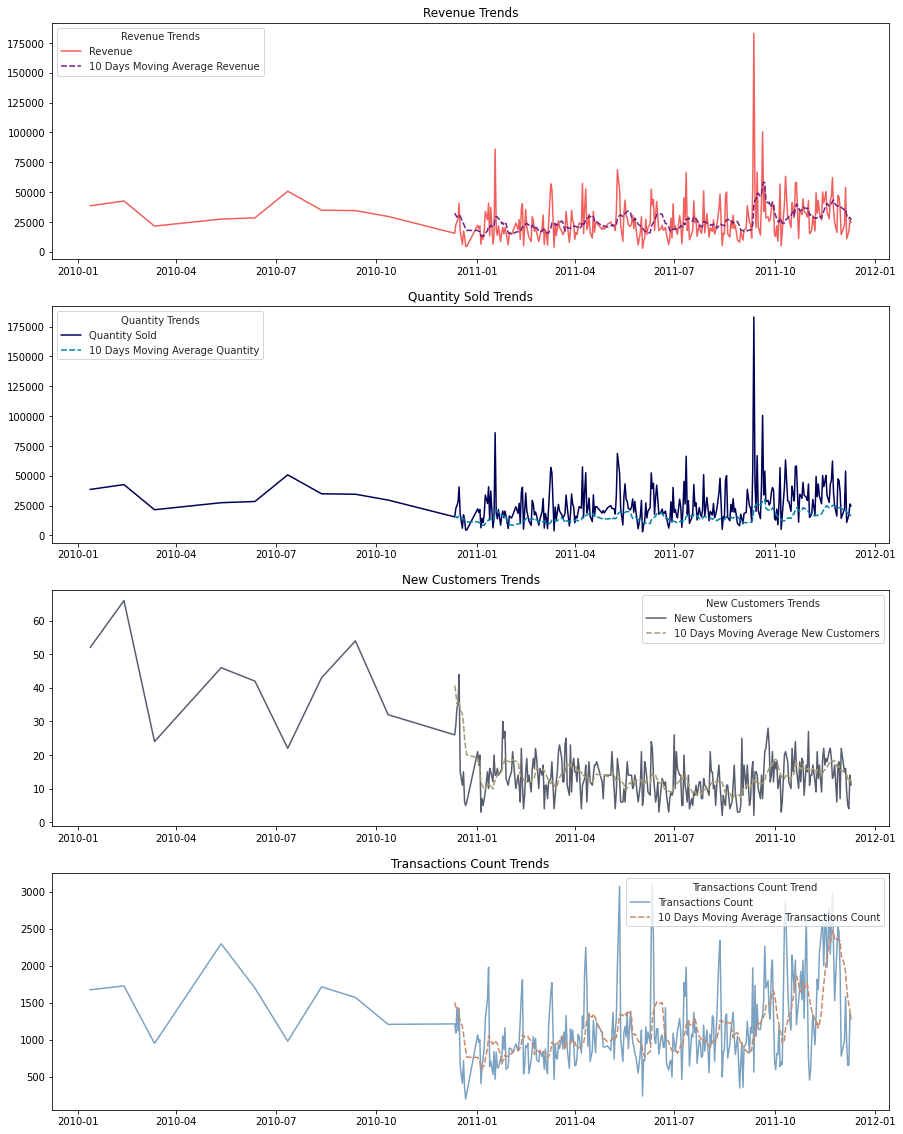

In [0]:
serach_data_trends(pandas_df)


- serach_data_trends
- Revnue_by_month 
- Comparision_for_the_month_of_December

In [0]:
def revnue_by_month(df):
  fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,20))
  rev = df[(df['TotalPrice']>0)&(df['InvoiceDate'].dt.year==2011)]
  rev['Transactions Count'] = 1
  rev = rev.groupby(rev['InvoiceDate'].dt.month).agg({'TotalPrice':'sum',
                                                    'Quantity': 'sum',
                                                    'CustomerID': 'count',
                                                  'Transactions Count':'sum'})
  rev = rev.reset_index()
  rev['Month'] = rev['InvoiceDate'].apply(lambda x: calendar.month_abbr[x])
  rev = rev.rename({'TotalPrice':'Revenue'},axis=1)
  cust = df.groupby('CustomerID').first().reset_index()[['CustomerID','InvoiceDate']]
  cust = cust.groupby(cust.InvoiceDate.dt.month).agg({'CustomerID':'count'})
  cust = cust.reset_index()
  cust['Month'] = cust['InvoiceDate'].apply(lambda x: calendar.month_abbr[x])


  sns.set_style("whitegrid")
  sns.barplot(data=rev, x=rev.Month, y='Revenue', palette='magma_r', ax=ax[0])
  ax[0].title.set_text('Revenue by Months')
  add_value_labels(ax[0])

  sns.barplot(data=rev, x=rev.Month, y='Quantity',  palette='ocean', ax=ax[1])
  ax[1].title.set_text('Quantity Sold by Months')
  add_value_labels(ax[1])

  sns.barplot(data=cust, x=cust.Month, y='CustomerID',  palette='cividis', ax=ax[2])
  ax[2].title.set_text('New Customers by Months')
  fig.suptitle('Growth Month wise',fontsize=16)
  add_value_labels(ax[2])

  sns.barplot(data=rev, x=rev.Month, y='Transactions Count',  palette='twilight_shifted', ax=ax[3])
  ax[3].title.set_text('Transactions Count by Months')
  fig.suptitle('Growth Month wise',fontsize=16)
  add_value_labels(ax[3])

  plt.show()

<command-2541198078407701>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

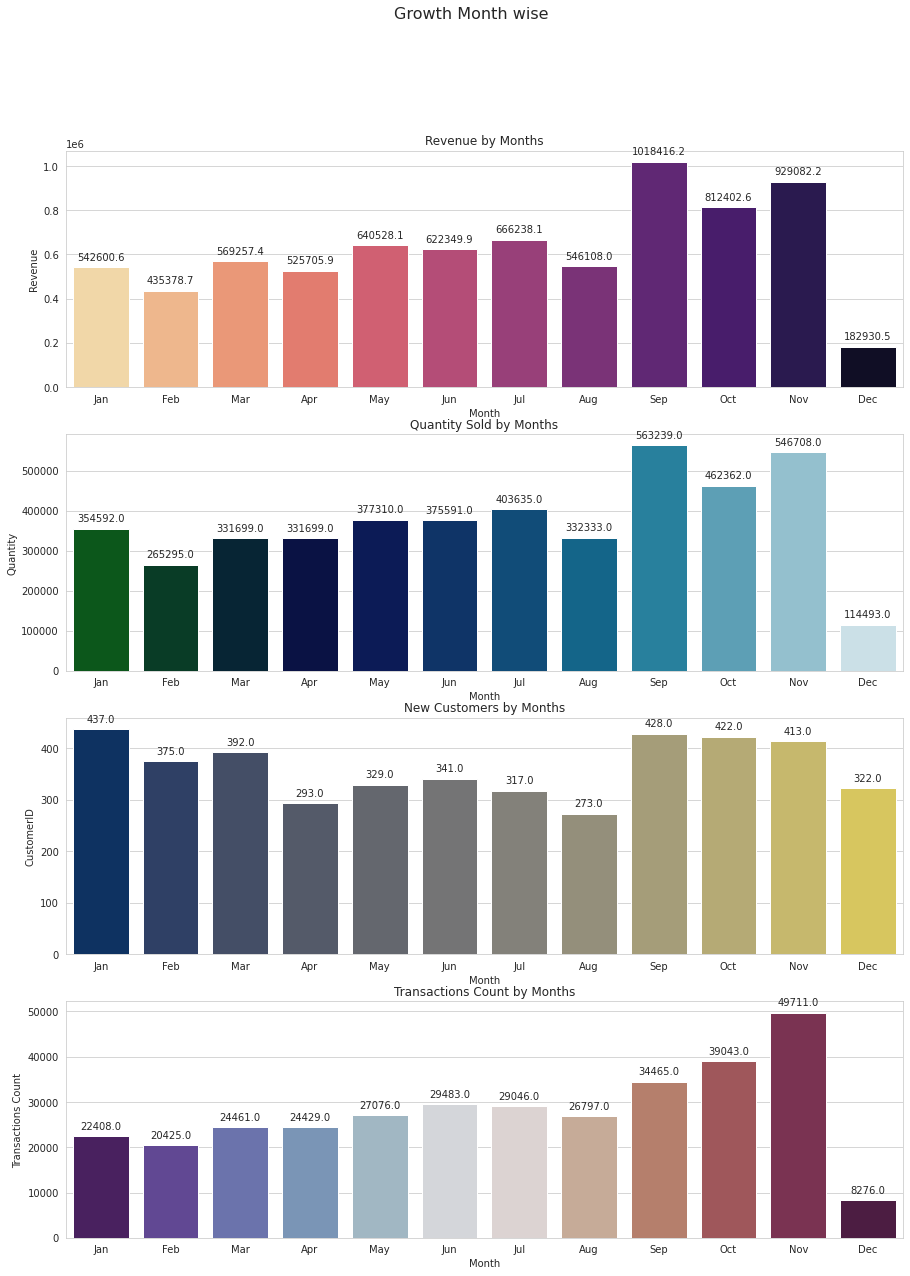

In [0]:
revnue_by_month(pandas_df)

xxx

In [0]:
def Comparision_for_the_month_of_December(df):
  sales_comp = df[(df['InvoiceDate'].dt.month==12)&(df['TotalPrice']>=0)][['InvoiceDate','TotalPrice','Quantity']]
  sales_comp['Transactions Count'] = 1
  sales_comp = sales_comp.groupby(sales_comp['InvoiceDate'].dt.year)[['TotalPrice','Quantity','Transactions Count']].sum()
  fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,5))

  sns.set_style("whitegrid")
  sns.barplot(data=sales_comp, x=sales_comp.index, y='TotalPrice', palette='magma_r', ax=ax[0])
  ax[0].title.set_text('Revenue Comparision')
  ax[0].set_ylabel('Revenue')
  ax[0].set_xlabel('December of Year')
  add_value_labels(ax[0])

  sns.barplot(data=sales_comp, x=sales_comp.index, y='Quantity',  palette='ocean', ax=ax[1])
  ax[1].title.set_text('Quantity Sold Comparision')
  add_value_labels(ax[1])
  ax[1].set_xlabel('December of Year')

  sns.barplot(data=sales_comp, x=sales_comp.index, y='Transactions Count',  palette='twilight_shifted', ax=ax[2])
  ax[2].title.set_text('Transactions Count Comparision')
  add_value_labels(ax[2])
  ax[2].set_xlabel('December of Year')

  fig.suptitle('Comparision for the month of December in 2020 and 2021',fontsize=16)

  plt.show()

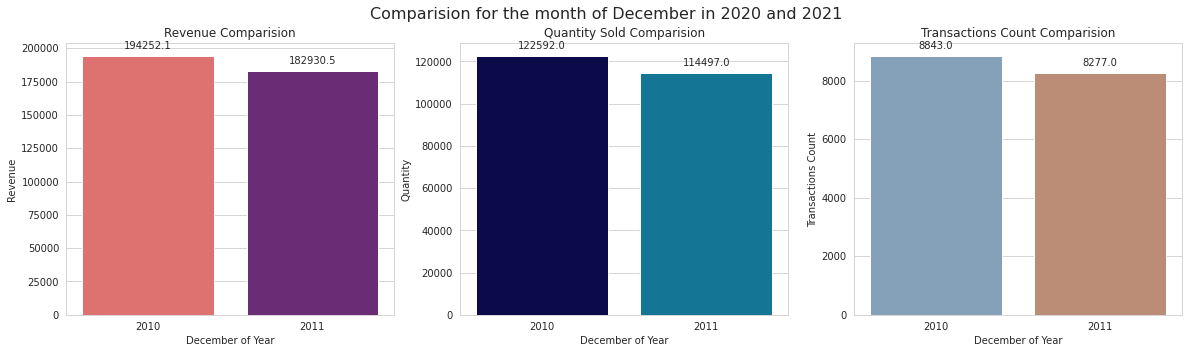

In [0]:
Comparision_for_the_month_of_December(pandas_df)

In [0]:
def Revenue_and_Quantity_by_Sale_Week_Day_Wise(df):
  fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,5))
  sns.set_style("whitegrid")

  week = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
  week = week.groupby(week['InvoiceDate'].dt.weekday)[['TotalPrice','Quantity']].sum()
  week = week.reset_index()
  week['Week'] = week['InvoiceDate'].apply(lambda x: calendar.day_name[x])

  sns.lineplot(data = week, x=week.Week, y='Quantity', marker='o', sort = False, ax=ax)
  ax2 = ax.twinx()
  sns.barplot(data = week, x=week.Week, y='TotalPrice', alpha=0.5, ax=ax2)
  fig.suptitle('Revenue and Quantity by Sale Week Day Wise',fontsize=16)
  add_value_labels(ax2)

  plt.show()

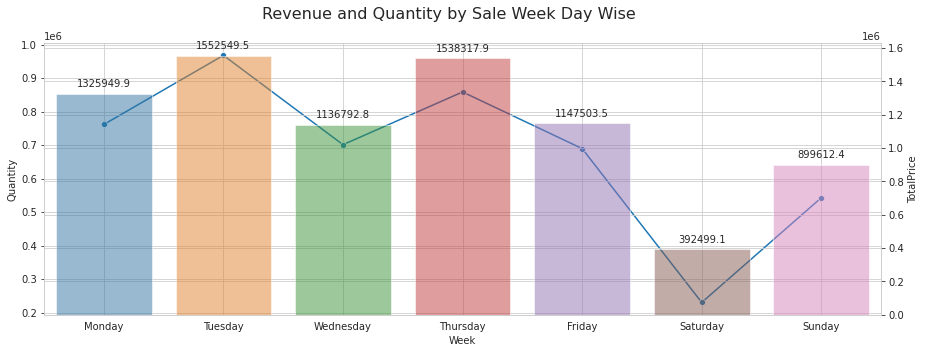

In [0]:
Revenue_and_Quantity_by_Sale_Week_Day_Wise(pandas_df)

In [0]:
def Revenue_and_Quantity_by_Sale_Hourwise(df):
  fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
  sns.set_style("whitegrid")

  day = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
  day = day.groupby(day['InvoiceDate'].dt.hour)[['TotalPrice','Quantity']].sum()

  sns.barplot(data = day, x=day.index, y='TotalPrice', alpha=1, ax=ax[0])
  sns.lineplot(data = day, x=day.index, y='Quantity', marker='o', sort = False, ax=ax[1])
  fig.suptitle('Revenue and Quantity by Sale Hourwise',fontsize=16)
  add_value_labels(ax[0])
  plt.show()

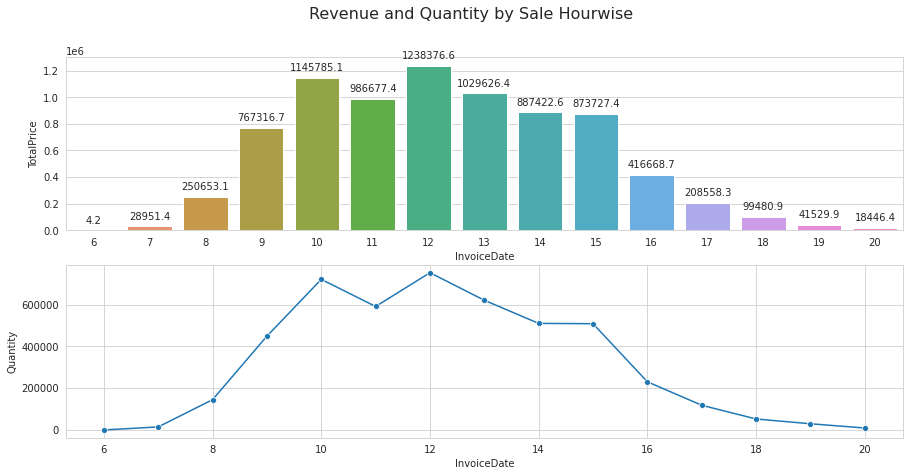

In [0]:
Revenue_and_Quantity_by_Sale_Hourwise(pandas_df)

In [0]:
def Revenue_and_Quantity_by_Sale_Daywise(df):
  fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
  sns.set_style("whitegrid")

  date = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
  date = date.groupby(date['InvoiceDate'].dt.day)[['TotalPrice','Quantity']].sum()

  sns.barplot(data = date, x=date.index, y='TotalPrice', alpha=1, ax=ax[0])
  sns.lineplot(data = date, x=date.index, y='Quantity', marker='o', sort = False, ax=ax[1])
  fig.suptitle('Revenue and Quantity by Sale Daywise',fontsize=16)

  plt.show()

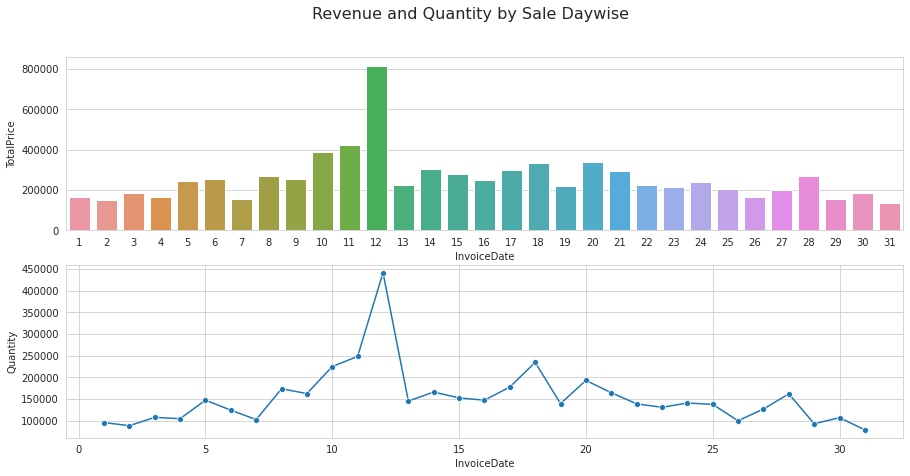

In [0]:
Revenue_and_Quantity_by_Sale_Daywise(pandas_df)

In [0]:
def Revenue_and_Quantity_by_Sale_Quarterly_for_2011(df):
  fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
  sns.set_style("whitegrid")

  q = df[(df['TotalPrice']>=0)&(df['InvoiceDate'].dt.year==2011)][['InvoiceDate','TotalPrice','Quantity']]
  q = q.groupby(q['InvoiceDate'].dt.quarter)[['TotalPrice','Quantity']].sum()

  sns.barplot(data = q, x=q.index, y='TotalPrice', alpha=0.7, ax=ax[0])
  sns.lineplot(data = q, x=q.index, y='Quantity', marker='o', sort = False, ax=ax[1])
  fig.suptitle('Revenue and Quantity by Sale Quarterly for 2011',fontsize=16)
  add_value_labels(ax[0])
  ax[1].set_xticklabels(['',1,'',2,'',3,'',4])
  plt.show()

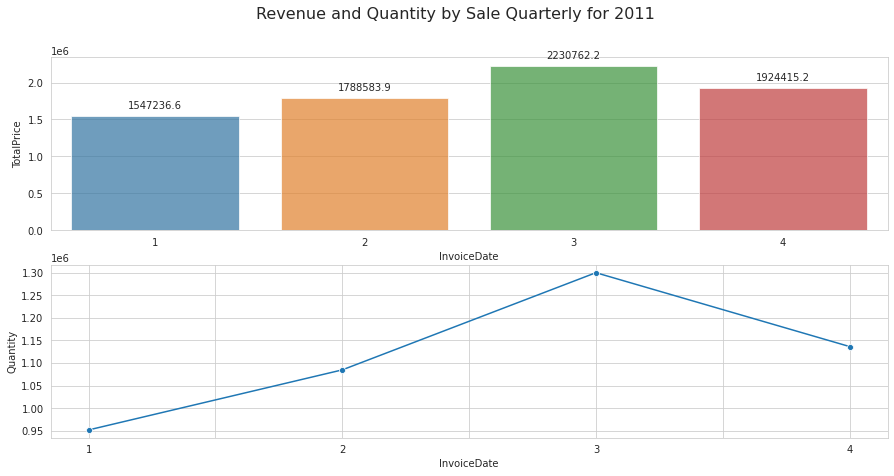

In [0]:
Revenue_and_Quantity_by_Sale_Quarterly_for_2011(pandas_df)

- Regionwise Analysis

In [0]:
def Regionwise_Analysis(df):
  reg = df[df['TotalPrice']>=0].groupby('Country').agg({'TotalPrice':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count'})
  fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,30))
  g1 = sns.barplot(x=reg['TotalPrice'], y=reg.index, alpha=1, ax=ax[0],palette='Reds', orient='h')
  g2 = sns.barplot(x=reg['Quantity'], y=reg.index, alpha=1, ax=ax[1], palette='Blues',orient='h')
  g3 = sns.barplot(x=reg['CustomerID'], y=reg.index, alpha=1, ax=ax[2], palette='Greens', orient='h')
  ax[2].title.set_text('Customers Count by Country')
  ax[2].set_xlabel("Customers (Log Scale)")
  ax[1].title.set_text('Quantity Sold by Country')
  ax[1].set_xlabel("Quantity (Log Scale)")
  ax[0].title.set_text('Revenue by Country')
  ax[0].set_xlabel("Revenue (Log Scale)")
  g1.set_xscale("log")
  g2.set_xscale("log")
  g3.set_xscale("log")
  plt.show()

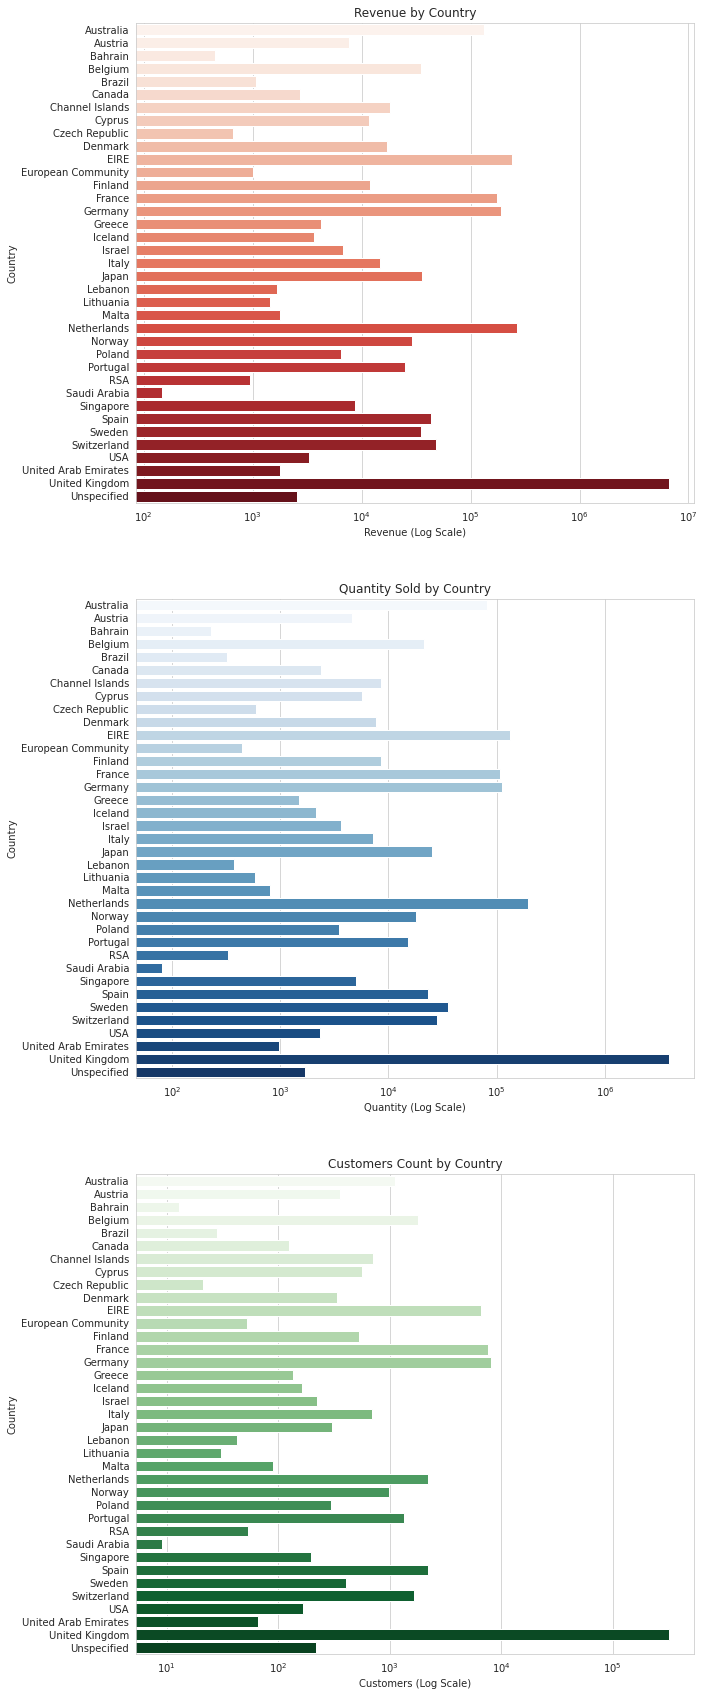

In [0]:
Regionwise_Analysis(pandas_df)

In [0]:
import squarify
def Customers_Count_by_Country(df):
  reg = df[df['TotalPrice']>=0].groupby('Country').agg({'TotalPrice':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count'})
  reg = reg[reg.index!='United Kingdom']
  fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,20))
  # Change color
  squarify.plot(sizes=reg['TotalPrice'], label=[str(x)+'\n'+str(y)+'K' for x,y in zip(reg.index,(reg['TotalPrice']/1000).round(2))], alpha=.6, ax=ax[0], color=mcolors.CSS4_COLORS )
  ax[0].title.set_text('Revenue by Country (Excluding UK)')
  squarify.plot(sizes=reg['Quantity'], label=[str(x)+'\n'+str(y)+'K' for x,y in zip(reg.index,(reg['Quantity']/1000).round(2))], alpha=.6, ax=ax[1], color=mcolors.CSS4_COLORS )
  ax[1].title.set_text('Quantity Sold by Country (Excluding UK)')
  r1 = reg[reg['CustomerID']!=0]
  squarify.plot(sizes=r1['CustomerID'], label=[str(x)+'\n'+str(y)+'K' for x,y in zip(r1.index,(r1['CustomerID']/1000).round(2))], alpha=.6, ax=ax[2], color=mcolors.CSS4_COLORS )
  ax[2].title.set_text('Customers Count by Country (Excluding UK)')
  ax[0].axis('off')
  ax[1].axis('off')
  ax[2].axis('off')
  plt.show()

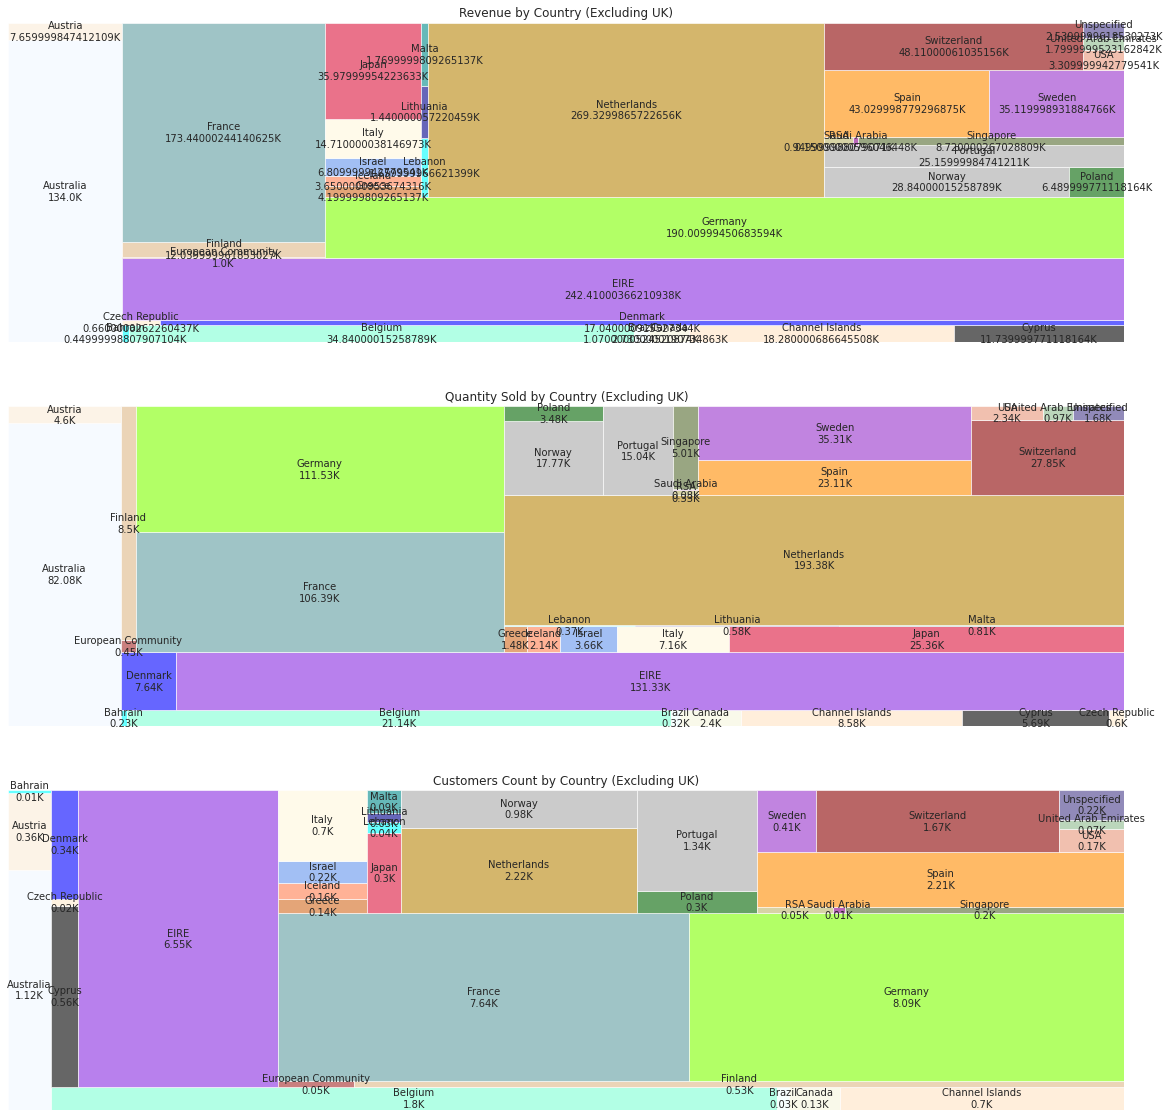

In [0]:
Customers_Count_by_Country(pandas_df)